# AML - Assignment N°4

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


>Nome: **Alessandro**  
Cognome: **Pigato**  
N° Matricola: **852482**  

The task of this assignment is Transfer Learning using a CNN pretrained on IMAGENET.
  
>* The CNN should be used as fixed feature extractor on a new task of your choice containing a number of classes in the range from 2 to 10. 
* The chosen "classical" classifier  
* For each transfer learning experiment:  
  -The details about the chosen layer  
  -The plot of the classification performance on train/val/test for the    ifferent layers considered  
  -The hyper-parameters used for training the "classical" classifier  


# Import libraries

In [23]:
import numpy as np
import keras
from keras.datasets import mnist
from keras import layers
from keras import models
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import optimizers
import seaborn as sns
import tensorflow as tf
import cv2
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import pathlib
import os

For this assignment has been used this dataset: https://www.kaggle.com/alxmamaev/flowers-recognition  
The dataset is composed of approximately 4242 flower photos and contains 5 class: daisy, dandelion, roses, sunflowers, tulips.

The data collection is based on the data flicr, google images, yandex images.


# Import Dataset

In the downloaded zip file from kaggle there is also a backup folder 'flowers' delete it using:

In [ ]:
import shutil
shutil.rmtree('/flowers/flowers', ignore_errors=True)

In [2]:
data='flowers'
folders=os.listdir("flowers")
print(folders)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [5]:
# Read and resize the images
size=(64,64)
image_train=[]
image_names=[]
image_labels=[]

for folder in folders:
    for each in os.listdir(os.path.join(data,folder)):
        if each.endswith('jpg'):
            image_names.append(os.path.join(data,folder,each))
            image_labels.append(folder)
            img=cv2.imread(os.path.join(data,folder,each))
            img_in=cv2.resize(img,size)
            img_in=np.expand_dims(img_in, axis=0)
            image_train.append(img_in)
        else:
            continue

## Pre Process

In [ ]:
# Here it is created a function for the pre-process of the images
def feature_list(data, model):
    feature_list = []
    for img_data in data:
        feature = model.predict(img_data)
        feature = np.array(feature)
        feature_list.append(feature.flatten())
    feature_list = np.array(feature_list)
    return  feature_list

In [7]:
X_train,X_val,Y_train,Y_val=train_test_split(image_train,image_labels,test_size=0.2)

# Training

In [8]:
# Import of the pre trained vgg16 with specified input shape
base_net = VGG16(input_shape=(64,64,3), weights='imagenet', include_top=False)

Features are analyzed below in 3 different point with the logistic regression.

## First experiment: VGG16 up to block3_pool

In [15]:
model_1 = Model(base_net.input, base_net.get_layer('block3_pool').output) 
model_1.summary()
train_feature = feature_list(X_train, model_1)
test_features = feature_list(X_val, model_1)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

Has been used the Logistic Regression as classifier with the following parameters:  
• solver=’newton-cg’  
• multi class=’multinomial’  
• max iter=200  

In [16]:
lr = LogisticRegression(random_state=1234, 
                         solver='newton-cg', 
                         multi_class='multinomial',
                         max_iter=200)

In the cell below there is a warning regarding the failure of the line search, this message disappera with max_iter = 4000, for computational reason i chose 200.

In [17]:
lr_fit = lr.fit(train_feature, Y_train)

C:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [19]:
# Here it is created a function for performance report
def pred_out(opt, features, label):
    class_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    opt.score(features, label)
    preds = opt.predict(features)
    print("\nAccuracy:: ", accuracy_score(label, preds))
    print("\nNumber of correctly identified imgaes: ",accuracy_score(label, preds, normalize=False)," out of ", len(features),"\n")
    %matplotlib inline
    matrix = confusion_matrix(label, preds)
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(matrix,annot=True,cbar=True,cmap="YlGnBu", fmt="d")
    plt.tight_layout()
    locs_x, labels_x=plt.xticks()
    x_ticks = []
    plt.xticks(locs_x,class_labels, rotation=45)
    locs_y, labels_y=plt.yticks()
    y_ticks = []
    plt.yticks(locs_y,class_labels, rotation=0)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    return preds


Accuracy::  0.9988432620011567

Number of correctly identified imgaes:  3454  out of  3458 



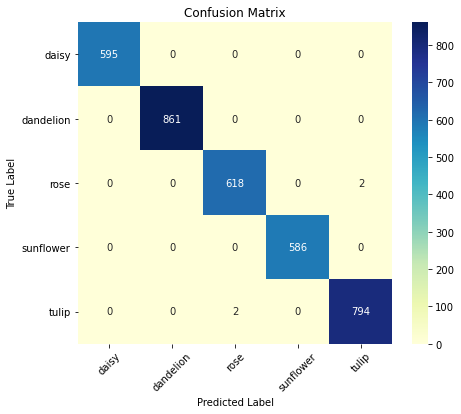

In [26]:
pred_t = pred_out(lr_fit, train_feature, Y_train)


Accuracy::  0.7606936416184971

Number of correctly identified imgaes:  658  out of  865 



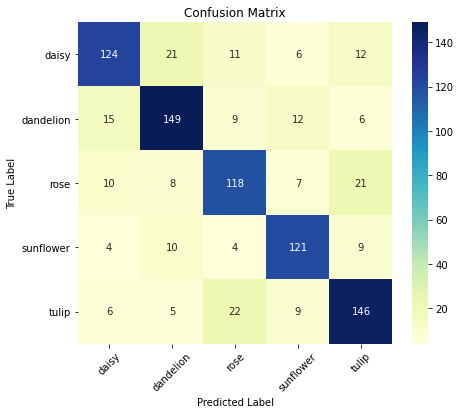

In [24]:
pred_y = pred_out(lr_fit, test_features, Y_val)

In [29]:
class_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
print("Results on Test \n", classification_report(Y_val, pred_y, target_names=class_labels))
print(" \nResults on Train \n", classification_report(Y_train, pred_t, target_names=class_labels))

Results on Test 
               precision    recall  f1-score   support

       daisy       0.78      0.71      0.74       174
   dandelion       0.77      0.78      0.78       191
        rose       0.72      0.72      0.72       164
   sunflower       0.78      0.82      0.80       148
       tulip       0.75      0.78      0.76       188

    accuracy                           0.76       865
   macro avg       0.76      0.76      0.76       865
weighted avg       0.76      0.76      0.76       865

 
Results on Train 
               precision    recall  f1-score   support

       daisy       1.00      1.00      1.00       595
   dandelion       1.00      1.00      1.00       861
        rose       1.00      1.00      1.00       620
   sunflower       1.00      1.00      1.00       586
       tulip       1.00      1.00      1.00       796

    accuracy                           1.00      3458
   macro avg       1.00      1.00      1.00      3458
weighted avg       1.00      1.00     

# Second experiment: VGG16 up to block2_pool

In [31]:
model2 = Model(base_net.input, base_net.get_layer('block2_pool').output) 
model2.summary()
train_feature2 = feature_list(X_train, model2)
test_features2 = feature_list(X_val, model2)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

In [32]:
lr_fit2 = lr.fit(train_feature2, Y_train)

C:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



Accuracy::  0.9988432620011567

Number of correctly identified imgaes:  3454  out of  3458 



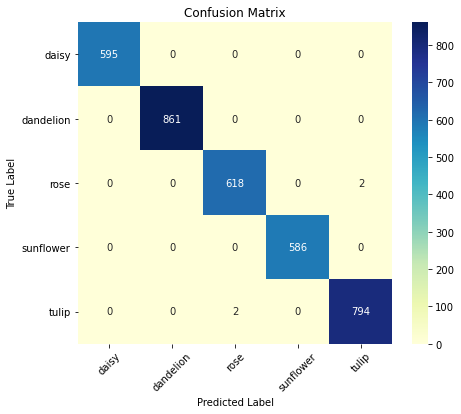

In [34]:
pred_t2 = pred_out(lr_fit2, train_feature2, Y_train)


Accuracy::  0.6578034682080924

Number of correctly identified imgaes:  569  out of  865 



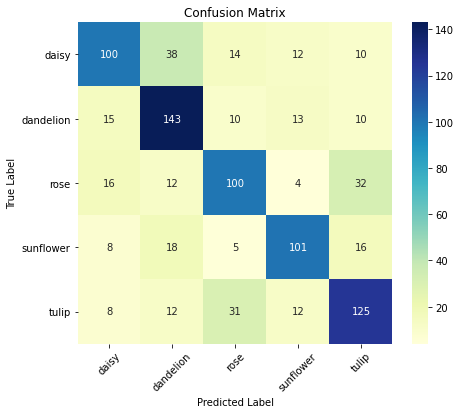

In [35]:
pred_y2 = pred_out(lr_fit2, test_features2, Y_val)

In [36]:
print("Results on Test \n", classification_report(Y_val, pred_y2, target_names=class_labels))
print(" \nResults on Train \n", classification_report(Y_train, pred_t2, target_names=class_labels))

Results on Test 
               precision    recall  f1-score   support

       daisy       0.68      0.57      0.62       174
   dandelion       0.64      0.75      0.69       191
        rose       0.62      0.61      0.62       164
   sunflower       0.71      0.68      0.70       148
       tulip       0.65      0.66      0.66       188

    accuracy                           0.66       865
   macro avg       0.66      0.66      0.66       865
weighted avg       0.66      0.66      0.66       865

 
Results on Train 
               precision    recall  f1-score   support

       daisy       1.00      1.00      1.00       595
   dandelion       1.00      1.00      1.00       861
        rose       1.00      1.00      1.00       620
   sunflower       1.00      1.00      1.00       586
       tulip       1.00      1.00      1.00       796

    accuracy                           1.00      3458
   macro avg       1.00      1.00      1.00      3458
weighted avg       1.00      1.00     

# Third experiment: VGG16 up to block5_conv2

In [37]:
model3 = Model(base_net.input, base_net.get_layer('block5_conv2').output) 
model3.summary()
train_feature3 = feature_list(X_train, model3)
test_features3 = feature_list(X_val, model3)
lr_fit3 = lr.fit(train_feature3, Y_train)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

C:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



Accuracy::  0.9988432620011567

Number of correctly identified imgaes:  3454  out of  3458 



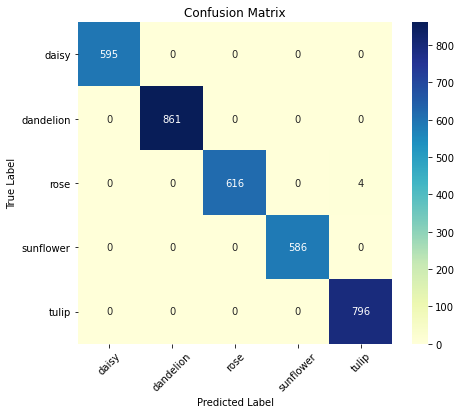

In [38]:
pred_t3 = pred_out(lr_fit3, train_feature3, Y_train)


Accuracy::  0.8

Number of correctly identified imgaes:  692  out of  865 



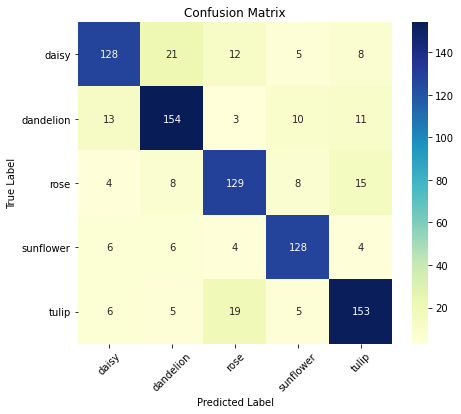

In [39]:
pred_y3 = pred_out(lr_fit3, test_features3, Y_val)

In [40]:
print("Results on Test \n", classification_report(Y_val, pred_y3, target_names=class_labels))
print(" \nResults on Train \n", classification_report(Y_train, pred_t3, target_names=class_labels))

Results on Test 
               precision    recall  f1-score   support

       daisy       0.82      0.74      0.77       174
   dandelion       0.79      0.81      0.80       191
        rose       0.77      0.79      0.78       164
   sunflower       0.82      0.86      0.84       148
       tulip       0.80      0.81      0.81       188

    accuracy                           0.80       865
   macro avg       0.80      0.80      0.80       865
weighted avg       0.80      0.80      0.80       865

 
Results on Train 
               precision    recall  f1-score   support

       daisy       1.00      1.00      1.00       595
   dandelion       1.00      1.00      1.00       861
        rose       1.00      0.99      1.00       620
   sunflower       1.00      1.00      1.00       586
       tulip       0.99      1.00      1.00       796

    accuracy                           1.00      3458
   macro avg       1.00      1.00      1.00      3458
weighted avg       1.00      1.00     

## Conclusion

Notice that train performance are always on top while the performance on the test are better in the third experiment the one with the high number of parameters 12M, also the first one with just 2M parameters is able to get 76% of accuracy.